### Projeto de Aprendizagem Automatica Avançada
#### Grupo:
* Diogo Azevedo 55773
* Lucas Silva 55922

# 0.1 Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 0.2 Unzip Raw Folder

In [ ]:
# !unzip '/content/drive/MyDrive/datasets/resized_dataset_512.zip' -d '/content/drive/MyDrive/datasets/raw_dataset'

# 0.3 Imports

In [ ]:
import pandas as pd
import os
import shutil

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

from sklearn.model_selection import train_test_split
import numpy as np

import os
import PIL
from PIL import Image
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, InputLayer

from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *

from ipywidgets import IntProgress
from IPython.display import display
import time
import random
import string

import seaborn as sn
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.pyplot import imshow

In [ ]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [ ]:
def circle_crop_v2(img):
    """
    Create circular crop around image centre
    """
    img = cv2.imread(img)
    img = crop_image_from_gray(img)

    height, width, depth = img.shape
    largest_side = np.max((height, width))
    img = cv2.resize(img, (largest_side, largest_side))

    height, width, depth = img.shape

    x = int(width / 2)
    y = int(height / 2)
    r = np.amin((x, y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)

    return img

In [ ]:
def get_data_distribution(df, column):
  data_distribution = {}
  for i in df[column].unique():
    data_distribution[i] = []
    data_distribution[i].append(df.loc[df[column] == i].shape[0])

  data_distribution_df = pd.DataFrame(data_distribution)

  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  langs = data_distribution_df.columns
  students = data_distribution_df.iloc[0]
  ax.bar(langs,students)
  plt.show()

  return data_distribution

In [ ]:
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

In [ ]:
def get_random_string(length):
    # choose from all lowercase letter
    letters = string.ascii_lowercase
    result_str = ''.join(random.choice(letters) for i in range(length))
    return result_str

In [ ]:
def plot_confusion_matrix(test_ds,model,binary = True):
  labels =  np.array([])
  predictions = np.array([])
  for x, y in test_ds:
    predictions = np.concatenate([predictions, model.predict_classes(x)])
    labels = np.concatenate([labels, y.numpy()])

  if binary:
    classes = ['No DR', 'DR']
  else:
    classes = ['Healthy', 'Mild', 'Moderate', 'Severe', 'Proliferate']

  cf = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()
  cf_df = pd.DataFrame(cf, index = classes, columns = classes)

  plt.figure(figsize = (10,7))
  sn.heatmap(cf_df, annot=True, fmt='g', cmap = 'Blues')
  plt.show()

In [ ]:
def plot_test_val(history, epochs):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(20, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

In [ ]:
def convert_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

In [ ]:
def convert_grayscale(path):
  image = cv2.imread(path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image = cv2.addWeighted (image,4, cv2.GaussianBlur( image , (0,0) , 512/10) ,-4 ,128)
  
  return image

In [ ]:
def run_model(model, name, binary = True, epochs = 15, run_times = 5):

  # Initialize Logging variables
  if binary:
    test_recalls = np.array([])
    train_recalls = np.array([])
    val_recalls = np.array([])

  histories = []
  test_acuracys = np.array([])
  test_losses = np.array([])
  train_acuracys = np.array([])
  train_losses = np.array([])
  val_acuracys = np.array([])
  val_losses = np.array([])

  # Compile model
  if binary:
    # Binary
    model.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
                metrics=['accuracy',tf.keras.metrics.Recall()])
  else:
    # Categorical
    model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  # Model Summary and save initial weights
  model.summary()
  weights = model.save_weights('model.h5')

  for i in range(0,run_times):
    
    # Reset model weights
    model.load_weights('model.h5')

    # Fit model
    epochs=epochs
    history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs
    )

    # Append this iteration's model stats to logging variables
    if binary:
      test_recalls = np.array([])
      train_recalls = np.array([])
      val_recalls = np.array([])

    # Test stats
    if binary:
      loss, accuracy, recall = model.evaluate(test_ds)
    else:
      loss, accuracy = model.evaluate(test_ds)
    test_acuracys = np.append(test_acuracys,accuracy)
    test_losses = np.append(test_losses,loss)
    # Train stats
    train_acuracys = np.append(train_acuracys, history.history['accuracy'])
    train_losses = np.append(train_losses, history.history['loss'])
    # Validation stats
    val_acuracys = np.append(val_acuracys, history.history['val_accuracy'])
    val_losses = np.append(val_losses, history.history['val_loss'])
    # Save history for possible future ploting
    histories.append(history)

  # Append Model average stats and standar deviataion to it's dicionary entry
  if binary:
    stats[name]['train_recall_mean'] = train_acuracys.mean()
    stats[name]['train_recall_std'] = train_acuracys.std()

  stats[name]['train_acc_mean'] = train_acuracys.mean()
  stats[name]['train_acc_std'] = train_acuracys.std()
  stats[name]['val_acc_mean'] = val_acuracys.mean()
  stats[name]['val_acc_std'] = val_acuracys.std()
  stats[name]['test_acc_mean'] = test_acuracys.mean()
  stats[name]['test_acc_std'] = test_acuracys.std()

  return histories

In [ ]:
def plot_confusion_matrix(model, test_ds, bin= True):
  labels =  np.array([])
  predictions = np.array([])
  for x, y in test_ds:
    pred = np.array(model.predict_classes(x)).flatten()
    predictions = np.concatenate([predictions, pred])
    labels = np.concatenate([labels, y.numpy()])

  if bin:
    classes = ['No DR', 'DR']
  else:
    classes = ['Healthy', 'Mild', 'Moderate', 'Severe', 'Proliferate']

  cf = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()
  cf_df = pd.DataFrame(cf, index = classes, columns = classes)

  plt.figure(figsize = (10,7))
  sn.heatmap(cf_df, annot=True, fmt='g', cmap = 'Blues')
  plt.show()

In [ ]:
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions
img_size = (256, 256)
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    # display(Image(cam_path))

In [ ]:
def get_heatmap(model,img_code, folder_path, layer, class_names):

  # Remove last layer's softmax
  model.layers[-1].activation = None

  # Print what the top predicted class is
  path = os.path.join(folder_path, img_code + '.png')
  img = keras.preprocessing.image.load_img(path, target_size=(img_height, img_width))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))

  # Generate class activation heatmap
  heatmap = make_gradcam_heatmap(img_array, model, layer)

  # Display heatmap
  plt.matshow(heatmap)
  plt.show()
  return heatmap

# 1. Load Datasets

In [ ]:
labels = {}
for i in range(0,2):
  aux = os.walk('/content/drive/MyDrive/datasets/raw_dataset/test_dataset_categorical/' + str(i))
  for j in aux:
    labels[i] = j[2]

In [ ]:
for folder, images in labels.items():
  SRC_PATH = '/content/drive/MyDrive/datasets/raw_dataset/test_dataset_categorical/' + str(folder) + '/'
  TRG_PATH = '/content/drive/MyDrive/datasets/gray_scale/gray_scale_test_categorical/' + str(folder) + '/'
  for img in images:
    # print(img)
    image = circle_crop_v2(os.path.join(SRC_PATH,img))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.addWeighted (image,4, cv2.GaussianBlur( image , (0,0) , 512/10) ,-4 ,128)
    cv2.imwrite(os.path.join(TRG_PATH,img), image)
    # break

# 2. Create crop_dataset

In [ ]:
LABELS_PATH = '/content/drive/MyDrive/datasets/df_train.csv'

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/datasets/df_train.csv')
df.head()

,id_code,diagnosis,binary_target
0,000c1434d8d7,2,1
1,001639a390f0,4,1
2,0024cdab0c1e,1,1
3,002c21358ce6,0,0
4,005b95c28852,0,0


# 3. Balancing Dataset

## 3.1 Train, Test split

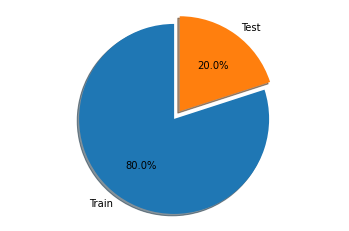

In [ ]:
# Definir x e y
x = df['id_code']
y = df['diagnosis']

# Definir Train, Test e Valid set
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.20, stratify=y, random_state=1)

# Definir tamanhos de fatias, legendas
sizes = [train_x.shape[0], test_x.shape[0]]
labels = 'Train', 'Test'
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

# Criar figura
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

## 3.2 Train and Test distributions

In [ ]:
df_train = df.iloc[train_x.index]
df_test = df.iloc[test_x.index]

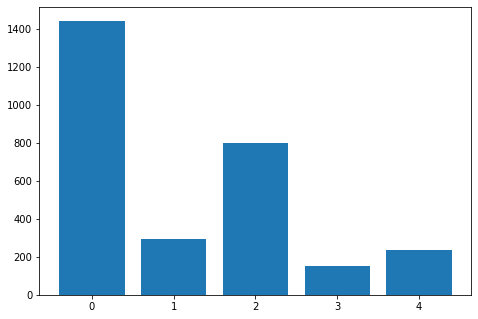

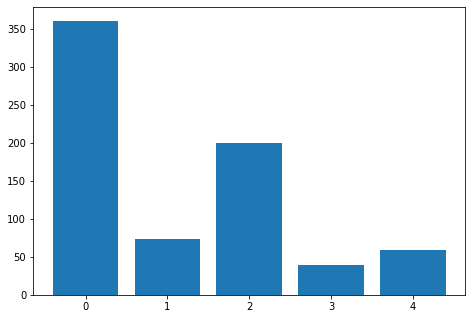

In [ ]:
# Data Augmentation
train_dist = get_data_distribution(df_train,'diagnosis')
test_dist = get_data_distribution(df_test,'diagnosis')

train_distribution = []
for i in range(0,5):
  train_distribution.append(train_dist[i][0])

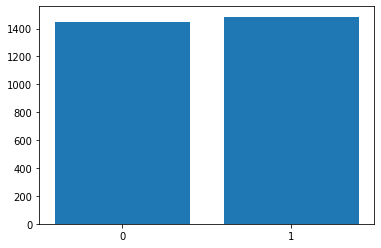

In [ ]:
zero = df_train.loc[df_train['binary_target'] == 0].shape[0]
one = df_train.loc[df_train['binary_target'] == 1].shape[0]
y = [zero,one]
x = [0,1]
energy = [5, 6, 15, 22, 24, 8]
x_pos = [i for i, _ in enumerate(x)]
plt.bar(x_pos, y)
plt.xticks(x_pos, x)
plt.show()

In [ ]:
df_test.to_csv('/content/drive/MyDrive/datasets/df_test.csv', index=False) 

## 3.3 Crop train dataset

In [ ]:
SRC_PATH = '/content/drive/MyDrive/datasets/raw_dataset/resized_dataset_512'
TRG_PATH = '/content/drive/MyDrive/datasets/croped/croped_dataset_full'

In [ ]:
load_bar = IntProgress(min=0, max=3662)
print('Cropping images...')
display(load_bar)

for row in df_train.iterrows():

  img = row[1].id_code
  folder = row[1].binary_target
  
  image = os.path.join(SRC_PATH, img+'.png')
  image_crop = circle_crop_v2(image)
  cv2.imwrite(os.path.join(TRG_PATH, img+'.png'),image_crop)
  
  load_bar.value += 1

Cropping images...


IntProgress(value=0, max=3662)

## 3.5 Oversample train data
Vamos fazer oversample a todas as classes as classes **1,2,3 e 4** para terem 800 casos e vamos manter o numero de casos da classe **0**.

In [ ]:
pd.DataFrame(train_dist)

,0,2,1,3,4
0,1444,799,296,154,236


In [ ]:
oversample_qts = []
target_qt = 800
for i in train_distribution:
  oversample_qts.append(800 - i)
oversample_qts

[-644, 504, 1, 646, 564]

In [ ]:
# Initialize df_train_aug
df_train_aug = df_train.copy()

# Directories
SRC_PATH = '/content/drive/MyDrive/datasets/croped/croped_dataset_full'
TRG_PATH = '/content/drive/MyDrive/datasets/croped/croped_dataset_categorical'

# Loading bars
copy_bars = []
aug_bars = []
for i in train_distribution:
  copy_bars.append(IntProgress(min=0, max=i))
for i in range(1,5):
  aug_bars.append(IntProgress(min=0, max=oversample_qts[i]))

# Classe 0
print('Copying Class 0...')
display(copy_bars[0])

for img in df_train.loc[df_train['diagnosis'] == 0]['id_code']:
  image = cv2.imread(os.path.join(SRC_PATH, img + '.png'))
  cv2.imwrite(os.path.join(TRG_PATH,'0',img+'.png'),image)
  copy_bars[0].value += 1
  

# Other Classes
for f in range(1,5):
  folder = str(f)
  paths = df_train.loc[df_train['diagnosis'] == f]['id_code'].to_list()

  print('Copying Class ' + folder + '...')
  display(copy_bars[f])

  for img in df_train.loc[df_train['diagnosis'] == f]['id_code']:
    image = cv2.imread(os.path.join(SRC_PATH, img + '.png'))
    cv2.imwrite(os.path.join(TRG_PATH,folder,img+'.png'), image)
    copy_bars[f].value += 1

  print('Oversampling Class ' + folder + ' with ' + str(oversample_qts[f]) + 'photo(s)' '...')
  display(aug_bars[f-1])

  for img in range(0,oversample_qts[f]):
    #Load and rotate and upload image
    image = cv2.imread(os.path.join(SRC_PATH, paths[img%len(paths)] + '.png'))
    angle = random.randint(20, 360)
    image_rot = rotate_image(image, angle)
    rand_str = get_random_string(3)
    name = os.path.join(TRG_PATH,folder,paths[img%len(paths)]+ '_' + rand_str + '_' + str(angle)+'.png')
    cv2.imwrite(name, image_rot)

    # Add row to df
    row = df_train.loc[df_train['id_code'] == paths[img%len(paths)]].copy()
    row.id_code = row.id_code + '_' + rand_str + '_' + str(angle)
    df_train_aug = pd.concat([row,df_train_aug]).reset_index(drop = True)
    aug_bars[f-1].value += 1

Copying Class 0...


IntProgress(value=0, max=1444)

Copying Class 1...


IntProgress(value=0, max=296)

Oversampling Class 1 with 504photo(s)...


IntProgress(value=0, max=504)

Copying Class 2...


IntProgress(value=0, max=799)

Oversampling Class 2 with 1photo(s)...


IntProgress(value=0, max=1)

Copying Class 3...


IntProgress(value=0, max=154)

Oversampling Class 3 with 646photo(s)...


IntProgress(value=0, max=646)

Copying Class 4...


IntProgress(value=0, max=236)

Oversampling Class 4 with 564photo(s)...


IntProgress(value=0, max=564)

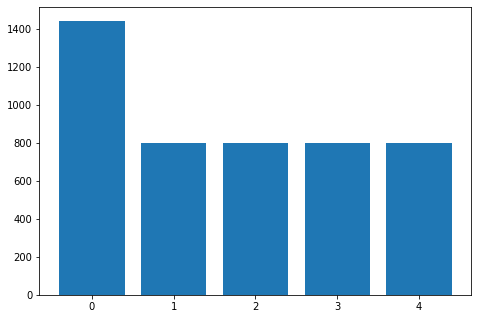

In [ ]:
train_aug_dist = get_data_distribution(df_train_aug,'diagnosis')

In [ ]:
df_train_aug.to_csv('/content/drive/MyDrive/datasets/df_train_aug.csv', index=False)  

# 3.6 Creating Test Dataset

In [ ]:
SRC_PATH = '/content/drive/MyDrive/datasets/raw_dataset/resized_dataset_512'
BINARY_PATH = '/content/drive/MyDrive/datasets/raw_dataset/test_dataset_binary'
CATEGORICAL_PATH = '/content/drive/MyDrive/datasets/raw_dataset/test_dataset_categorical'
copy_bar = IntProgress(min=0, max=i)

print('Copying test Dataset...')
display(copy_bar)

for row in df_test.iterrows():
  img = row[1]['id_code']
  diagnosis_binary_target = str(row[1]['binary_target'])
  diagnosis_folder = str(row[1]['diagnosis'])
  
  image = cv2.imread(os.path.join(SRC_PATH, img + '.png'))

  cv2.imwrite(os.path.join(BINARY_PATH,diagnosis_binary_target,img+'.png'),image)
  cv2.imwrite(os.path.join(CATEGORICAL_PATH,diagnosis_folder,img+'.png'),image)
  
  copy_bar.value += 1

Copying test Dataset...


IntProgress(value=0, max=4)

# 4. Setting up for models

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Initialize Stats Dictionary

In [ ]:
stats = {
    'Binary_raw': {},
    'Binary_grayscale': {},
    'Binary_sigmax': {},
    'Categorical_raw': {},
    'Categorical_grayscale': {},
    'Categorical_sigmax': {}
    }

# 5. Binary Model: Cropped Dataset 

## 5.1 Binary Model

In [ ]:
# Binary Model
model = tf.keras.models.Sequential([
                                    
# Standardize photos
layers.experimental.preprocessing.Rescaling(
    1./255, input_shape=(256, 256, 3)),

# This is the first convolution
tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(256, 256, 3)),
tf.keras.layers.MaxPooling2D(2, 2),

# The second convolution
tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),

tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# Flatten the results to feed into a DNN
tf.keras.layers.Flatten(),

# 512 neuron hidden layer
tf.keras.layers.Dense(512, activation='relu'),

# Only 1 output neuron. 
tf.keras.layers.Dense(1, activation='sigmoid')
])

## 5.2 Load Data

In [ ]:
batch_size = 16
img_height = 256
img_width = 256

data_dir = '/content/drive/MyDrive/datasets/croped/croped_dataset_binary'
test_dir = '/content/drive/MyDrive/datasets/raw_dataset/test_dataset_binary'

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3662 files belonging to 2 classes.
Using 2930 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3662 files belonging to 2 classes.
Using 732 files for validation.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  validation_split=0.999,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 733 files belonging to 2 classes.
Using 732 files for validation.


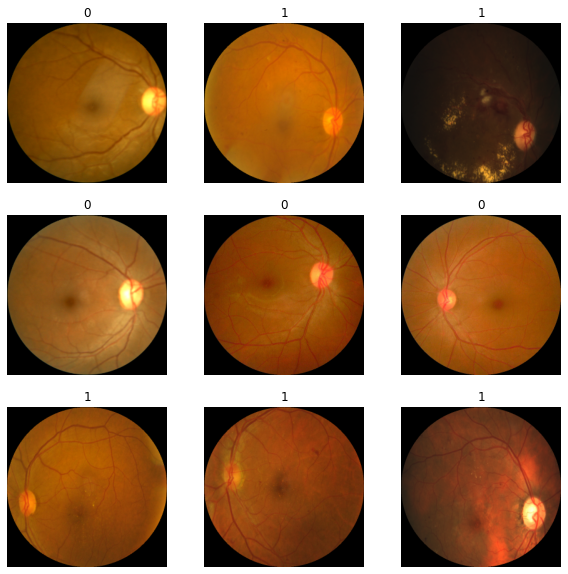

In [ ]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## 5.3 Run model

In [ ]:
histories = run_model(model, name = 'Binary_raw', binary = True, epochs = 15, run_times = 5)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 64)       

## 5.4 Results

In [ ]:
binary_sigmax_results = pd.DataFrame(stats['Binary_raw'],index=[0])
binary_sigmax_results[['train_recall_mean', 'train_acc_mean', 'val_acc_mean', 'test_acc_mean']]

,train_recall_mean,train_acc_mean,val_acc_mean,test_acc_mean
0,0.918407,0.918407,0.930036,0.851366


#### Train/Val accuracy plots

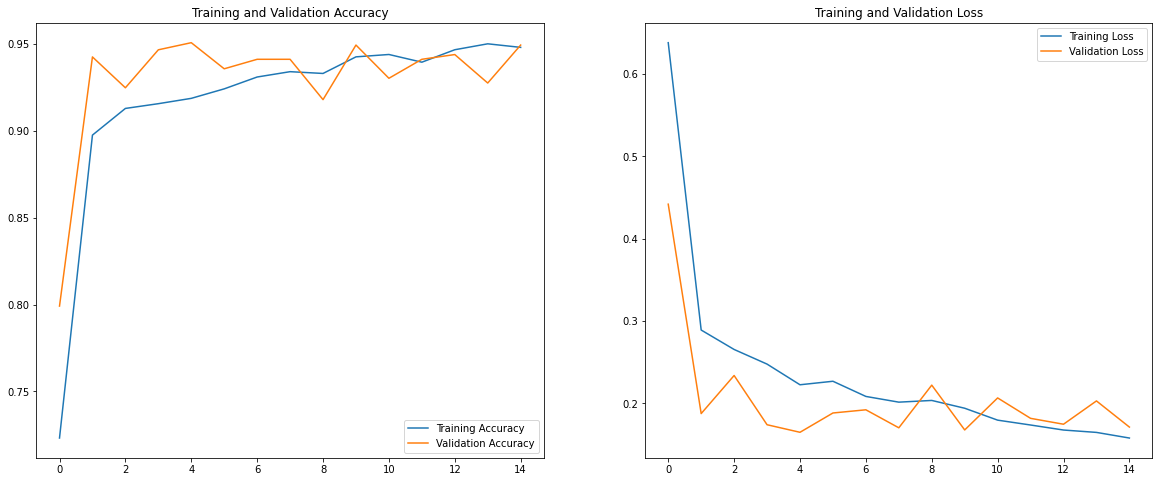

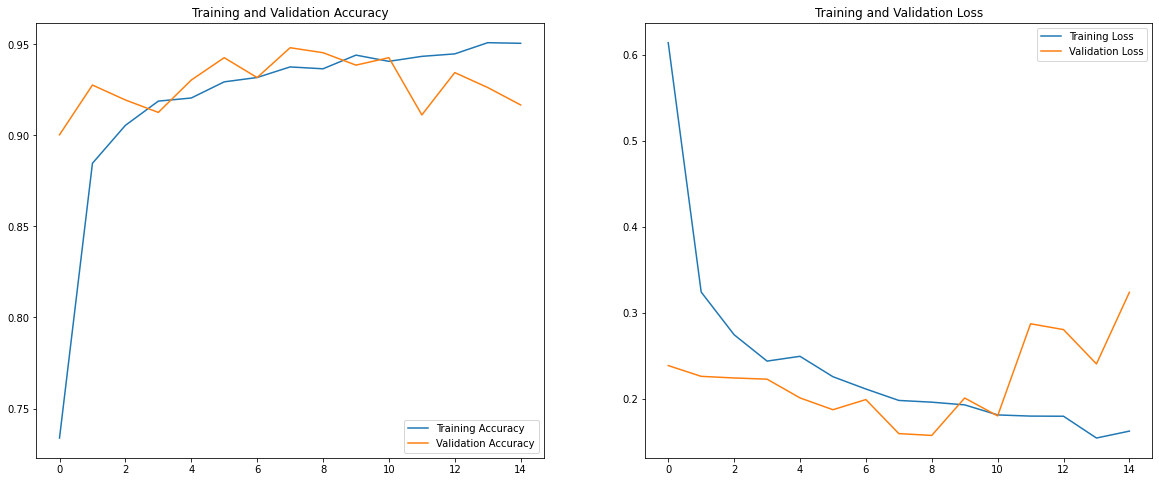

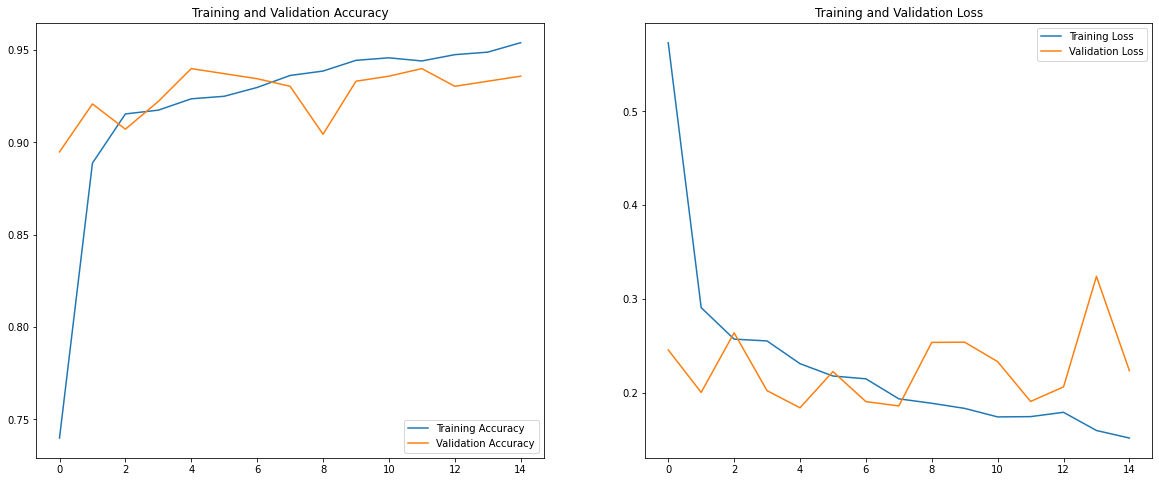

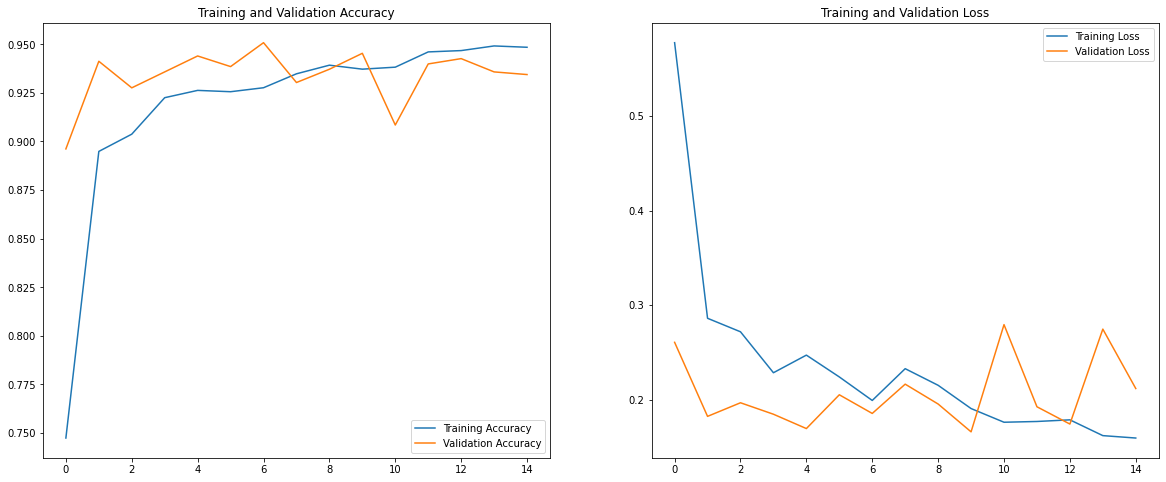

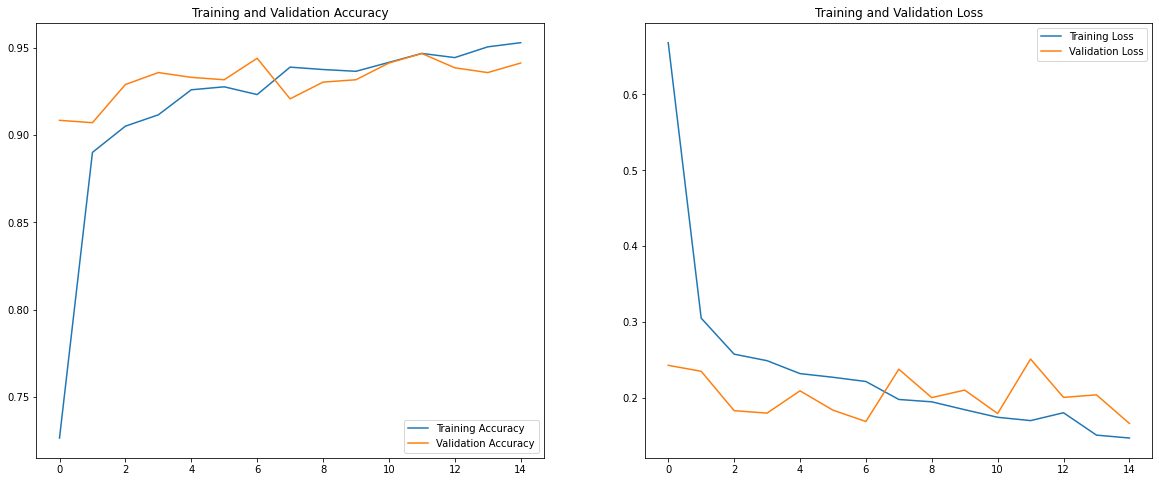

In [ ]:
for history in histories:
  plot_test_val(history,15)

#### Confusion Matrix

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


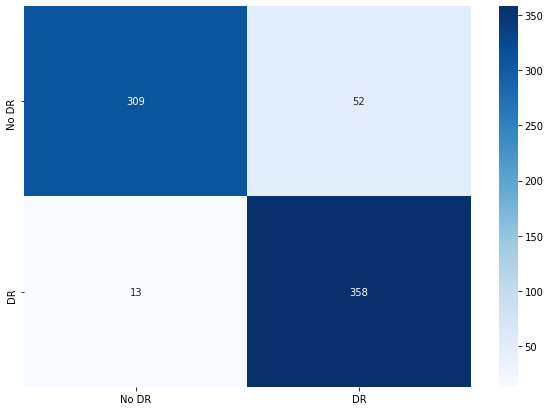

In [ ]:
plot_confusion_matrix(model,test_ds)

## 5.5 Save model

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/MyDrive/model_wights/raw_binary_model.h5")
print("Saved model to disk")

Saved model to disk


# 6. Binary Model: Contrast Grayscale Dataset

## 6.1 Binary Model

In [ ]:
# Binary Model
model = tf.keras.models.Sequential([
                                    
# Standardize photos
layers.experimental.preprocessing.Rescaling(
    1./255, input_shape=(img_height, img_width, 3)),

# This is the first convolution
tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2, 2),

# The second convolution
tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),

tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# Flatten the results to feed into a DNN
tf.keras.layers.Flatten(),

# 512 neuron hidden layer
tf.keras.layers.Dense(512, activation='relu'),

# Only 1 output neuron. 
tf.keras.layers.Dense(1, activation='sigmoid')
])

## 6.2 Load Data

In [ ]:
batch_size = 16
img_height = 256
img_width = 256

data_dir = '/content/drive/MyDrive/datasets/gray_scale/gray_scale_dataset_binary'
test_dir = '/content/drive/MyDrive/datasets/gray_scale/gray_scale_test_binary'

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3662 files belonging to 2 classes.
Using 2930 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3662 files belonging to 2 classes.
Using 732 files for validation.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  validation_split=0.999,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 733 files belonging to 2 classes.
Using 732 files for validation.


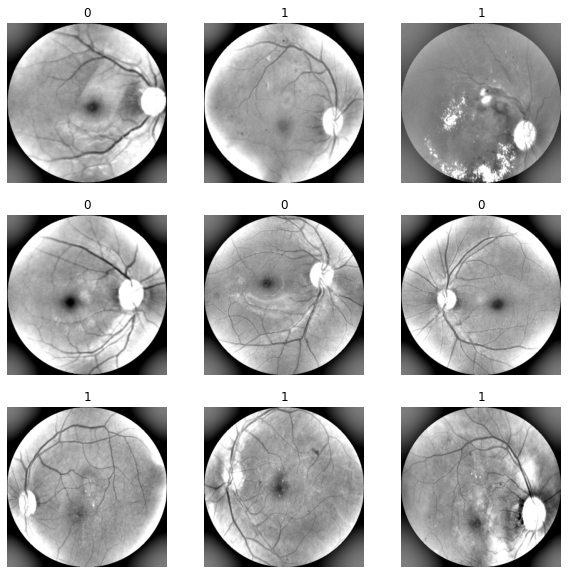

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## 6.3 Run model

In [ ]:
histories = run_model(model, name = 'Binary_grayscale', binary = True, epochs = 15, run_times = 5)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_8 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 30, 30, 64)       

## 6.4 Results

In [ ]:
binary_sigmax_results = pd.DataFrame(stats['Binary_grayscale'],index=[0])
binary_sigmax_results[['train_recall_mean', 'train_acc_mean', 'val_acc_mean', 'test_acc_mean']]

,train_recall_mean,train_acc_mean,val_acc_mean,test_acc_mean
0,0.912915,0.912915,0.883042,0.969672


#### Train/Val accuracy plots

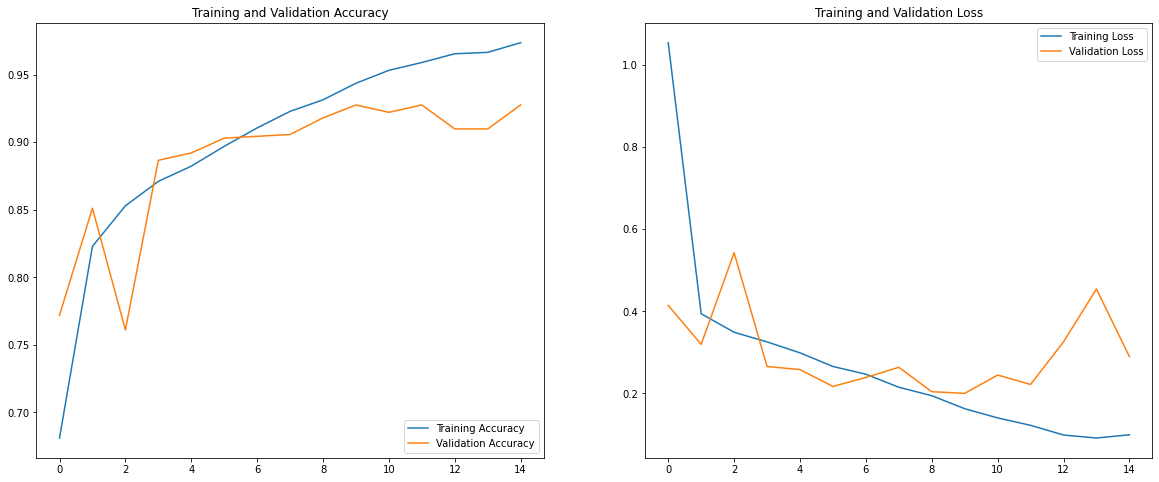

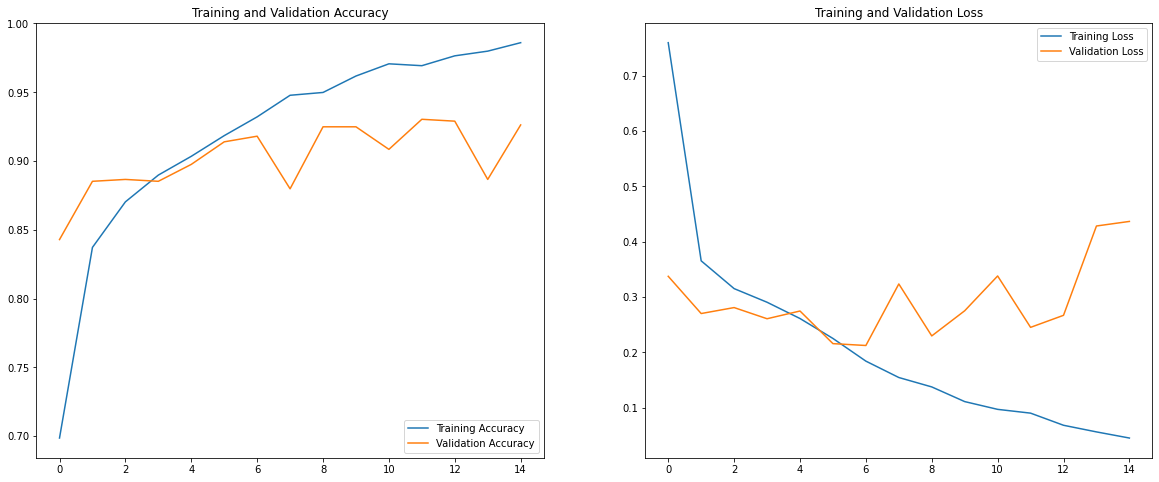

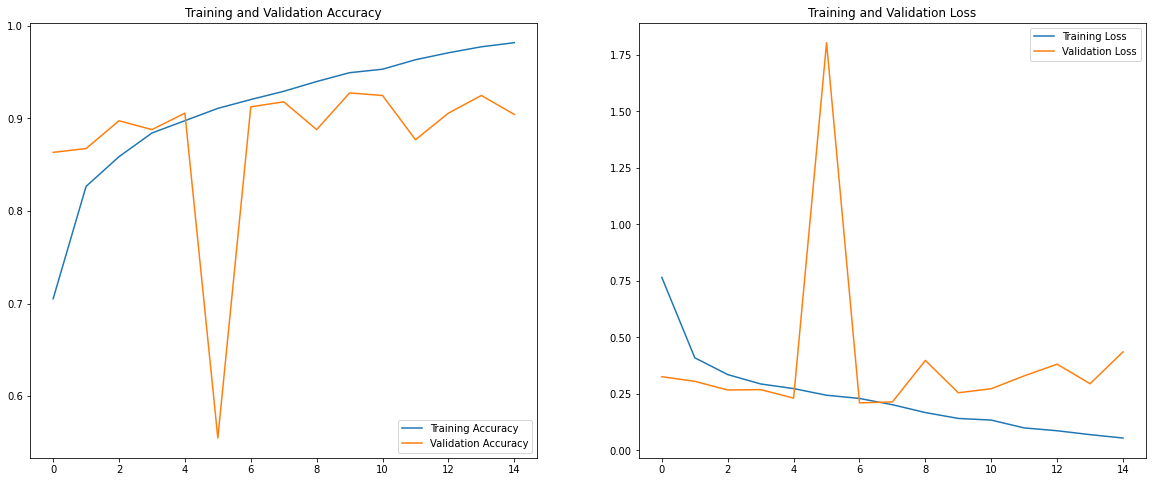

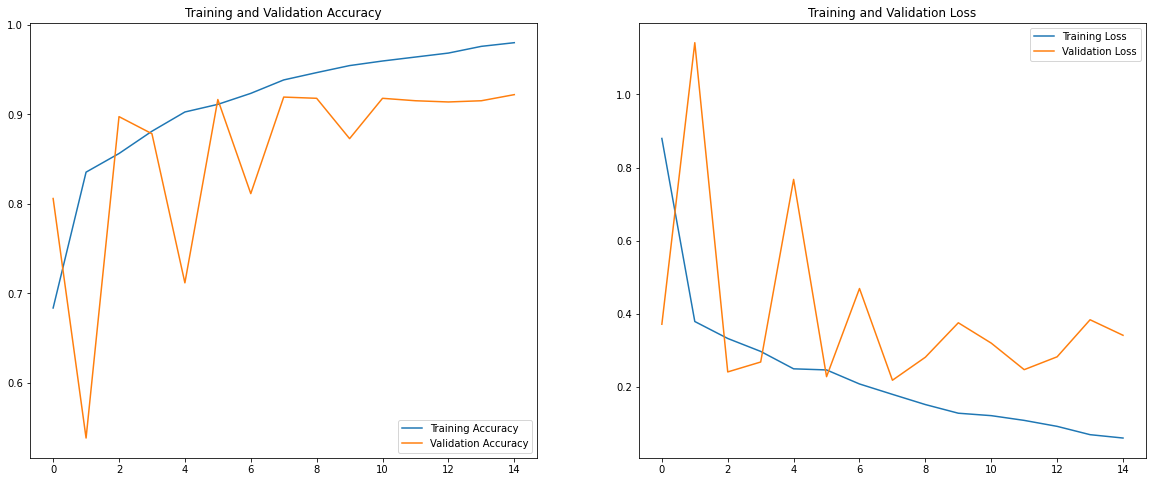

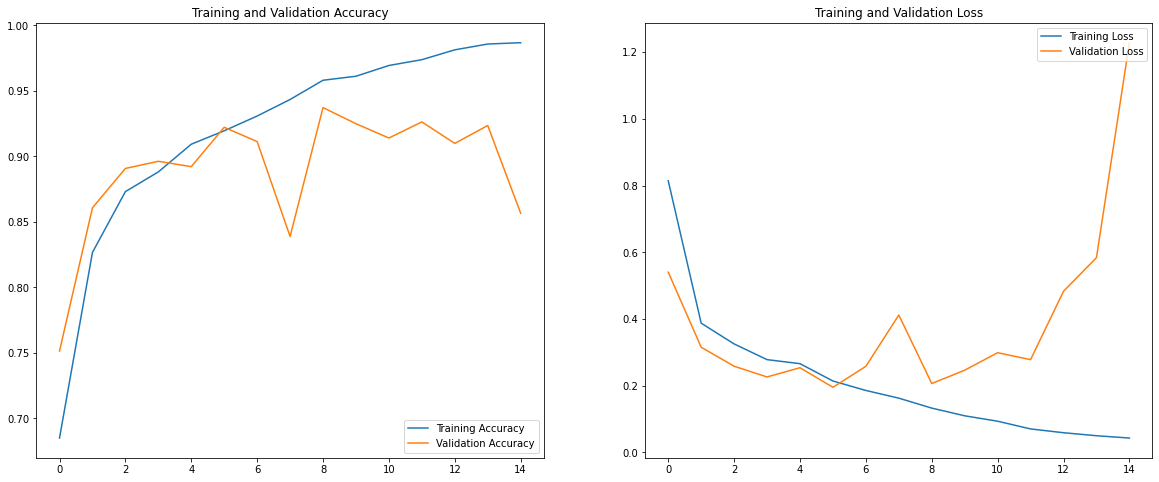

In [ ]:
for history in histories:
  plot_test_val(history,15)

#### Confusion Matrix

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


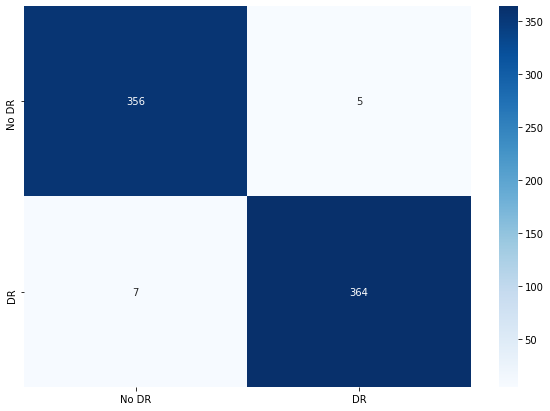

In [ ]:
plot_confusion_matrix(model,test_ds)

# 7. Binary Model: Sigmax Dataset

## 7.1 Binary Model

In [ ]:
# Binary Model
model = tf.keras.models.Sequential([
                                    
# Standardize photos
layers.experimental.preprocessing.Rescaling(
    1./255, input_shape=(img_height, img_width, 3)),

# This is the first convolution
tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(256, 256, 3)),
tf.keras.layers.MaxPooling2D(2, 2),

# The second convolution
tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),

tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# Flatten the results to feed into a DNN
tf.keras.layers.Flatten(),

# 512 neuron hidden layer
tf.keras.layers.Dense(512, activation='relu'),

# Only 1 output neuron. 
tf.keras.layers.Dense(1, activation='sigmoid')
])

## 7.2 Load Data

In [ ]:
batch_size = 16
img_height = 256
img_width = 256

data_dir = '/content/drive/MyDrive/datasets/sigmax/sigmax_dataset_binary'
test_dir = '/content/drive/MyDrive/datasets/sigmax/sigmax_test_binary'

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3662 files belonging to 2 classes.
Using 2930 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3662 files belonging to 2 classes.
Using 732 files for validation.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  validation_split=0.999,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 733 files belonging to 2 classes.
Using 732 files for validation.


In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## 7.3 Run model

In [ ]:
histories = run_model(model, name = 'Binary_sigmax', binary = True, epochs = 15, run_times = 5)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_7 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 30, 30, 64)       

## 7.4 Results

In [ ]:
binary_sigmax_results = pd.DataFrame(stats['Binary_sigmax'],index=[0])
binary_sigmax_results[['train_recall_mean', 'train_acc_mean', 'val_acc_mean', 'test_acc_mean']]

,train_recall_mean,train_acc_mean,val_acc_mean,test_acc_mean
0,0.941129,0.941129,0.902168,0.985792


#### Train/Val accuracy plots

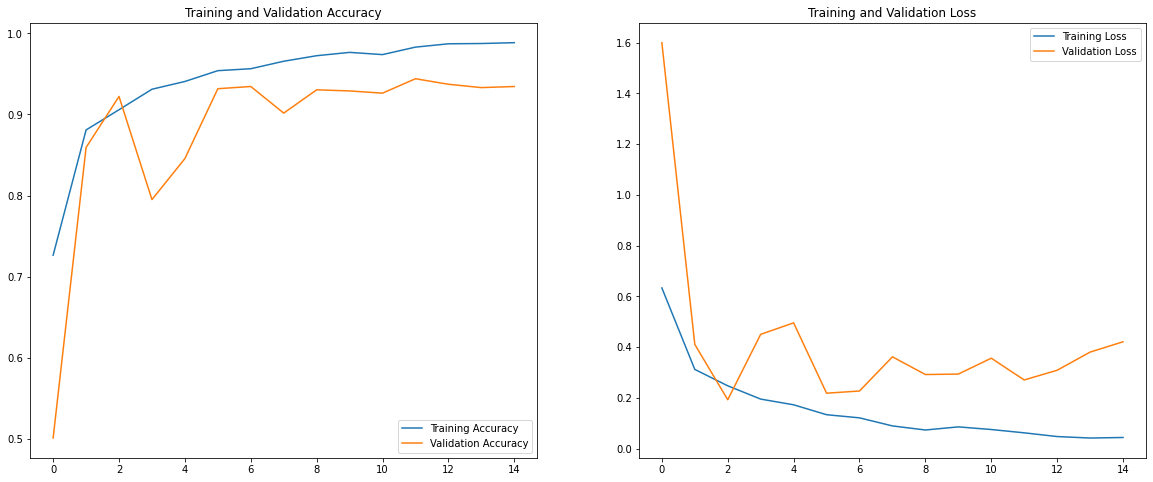

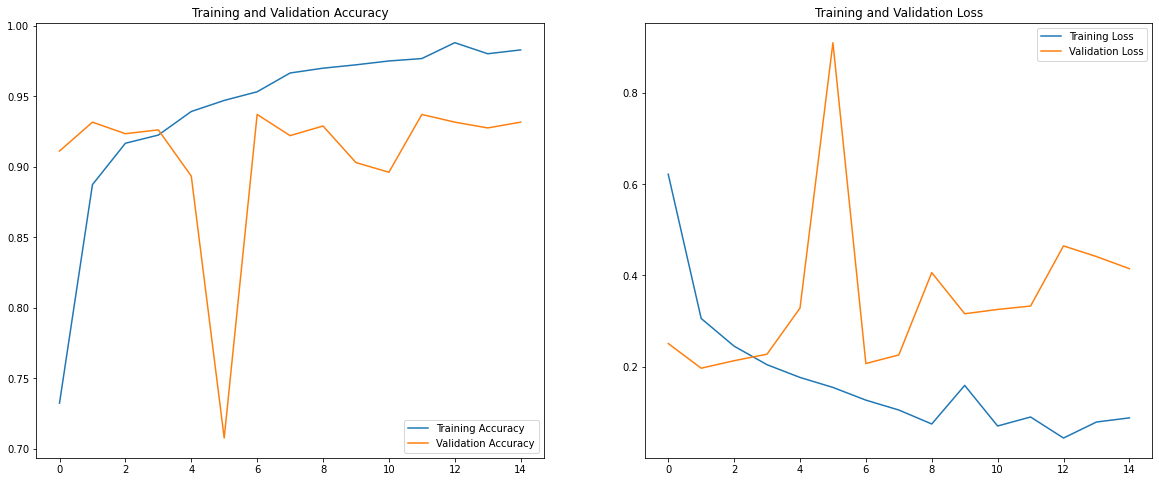

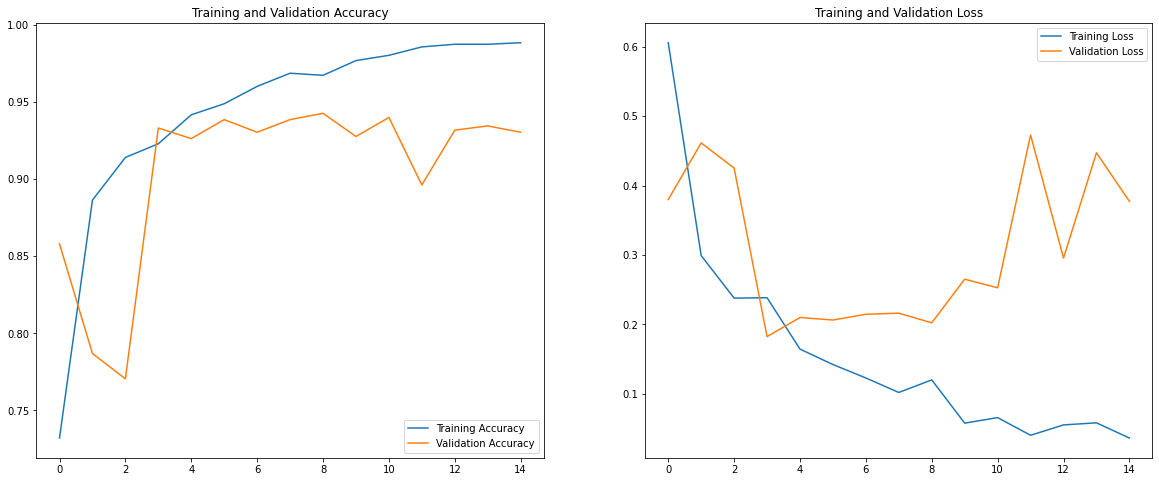

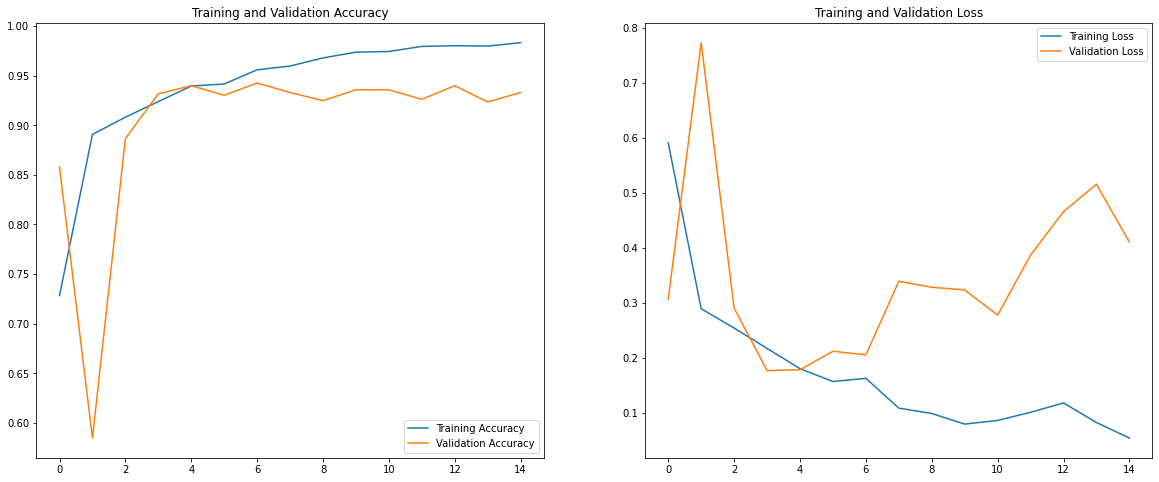

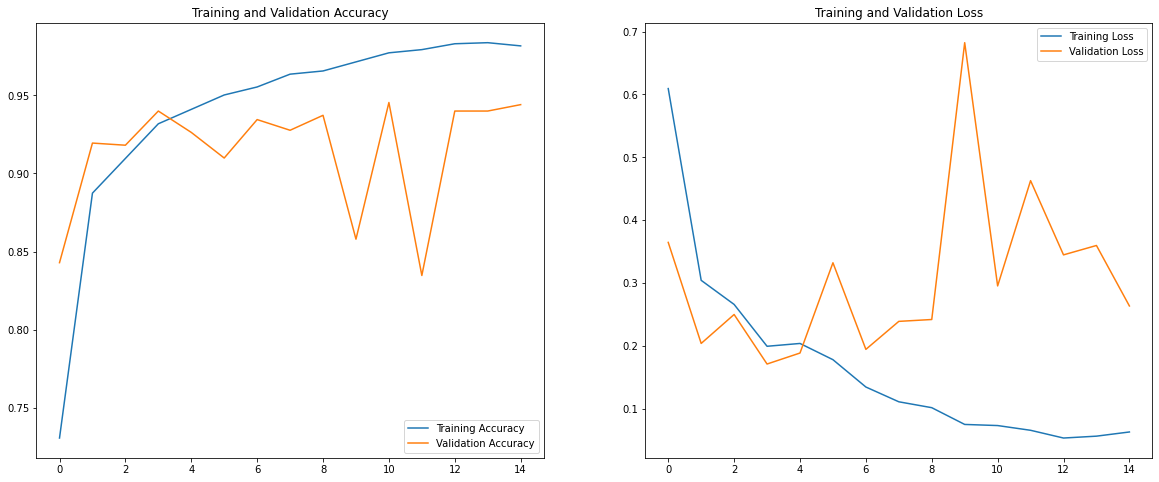

In [ ]:
for history in histories:
  plot_test_val(history,15)

#### Confusion Matrix

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


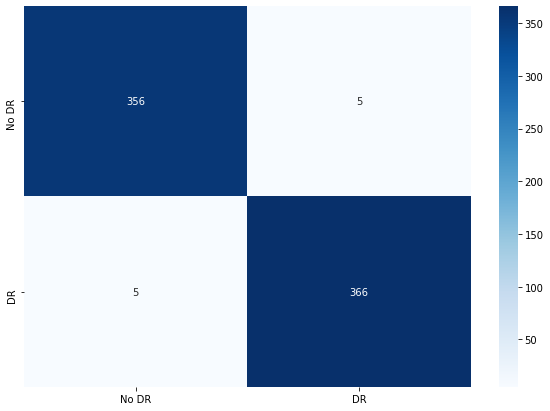

In [ ]:
plot_confusion_matrix(model,test_ds)

#  8. Categorical Model - Sigmax

## 8.1 Model

In [ ]:
# Modelo Categorico 1

num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Flatten(),

  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1, fill_mode = 'constant'),
    layers.experimental.preprocessing.RandomZoom(0.1, fill_mode = 'constant'),
  ]
)

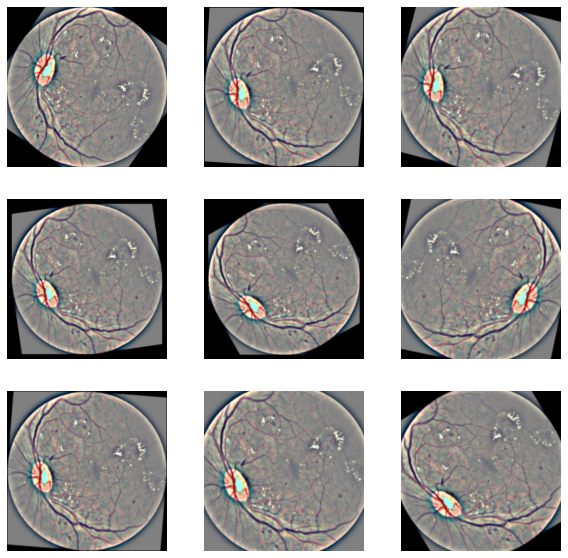

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


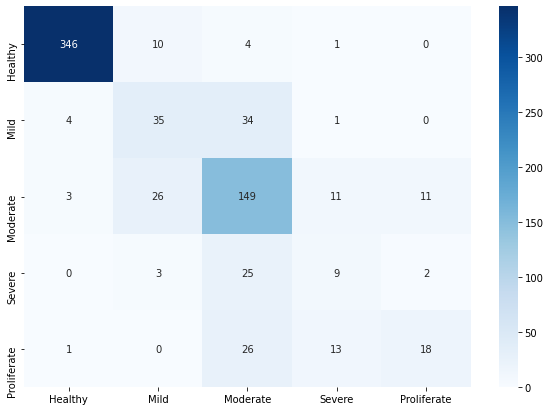

In [ ]:
plot_confusion_matrix(model_2,test_ds,bin=False)

## 8.2 Load Data

In [ ]:
batch_size = 32
img_height = 256
img_width = 256

data_dir = '/content/drive/MyDrive/datasets/sigmax/sigmax_dataset_categorical'
test_dir = '/content/drive/MyDrive/datasets/sigmax/sigmax_test_categorical'

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4644 files belonging to 5 classes.
Using 3716 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4644 files belonging to 5 classes.
Using 928 files for validation.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  validation_split=0.999,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 733 files belonging to 5 classes.
Using 732 files for validation.


## 8.3 Run Model

In [ ]:
histories = run_model(model, name = 'Categorical_sigmax', binary = False, epochs = 15, run_times = 5)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 64)       

In [ ]:
categorical_sigmax_results = pd.DataFrame(stats['Categorical_sigmax'],index=[0])
categorical_sigmax_results[['train_acc_mean', 'val_acc_mean', 'test_acc_mean']]

,train_acc_mean,val_acc_mean,test_acc_mean
0,0.763584,0.590417,0.707923


## 8.4 Results


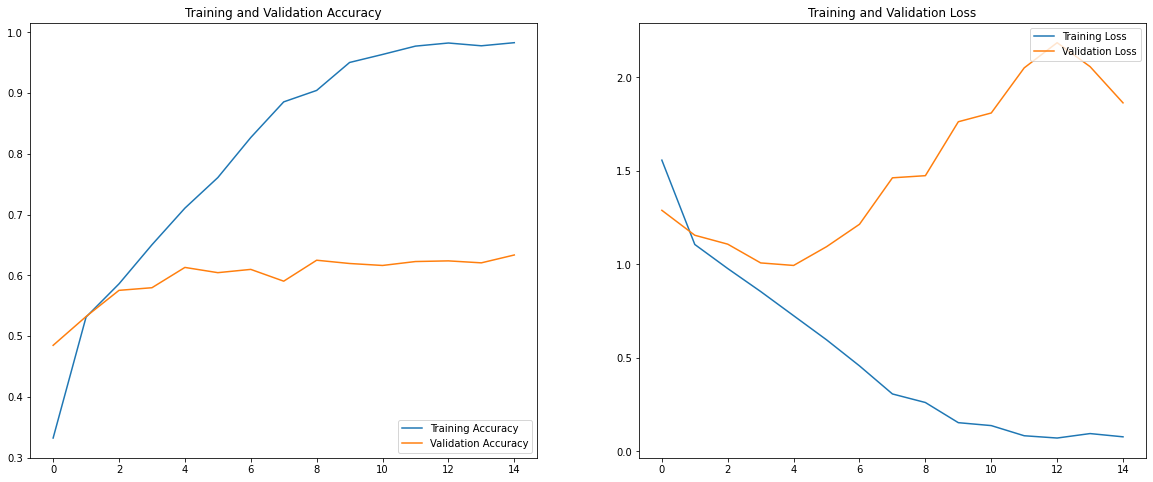

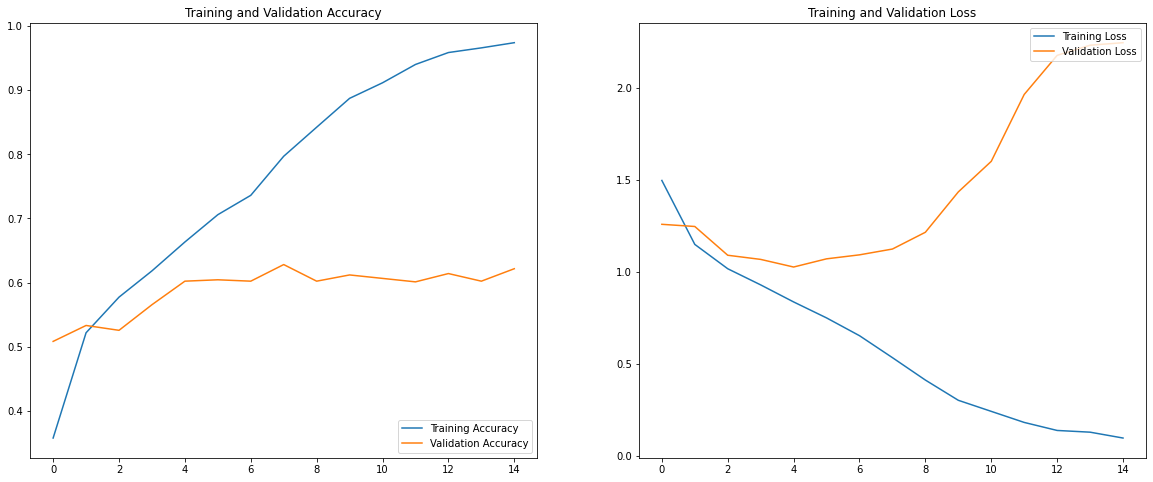

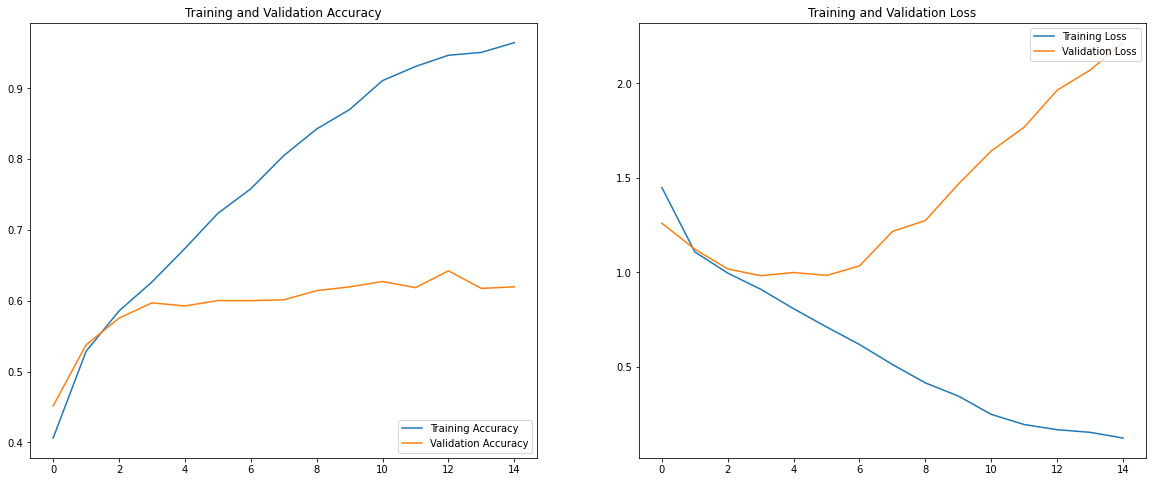

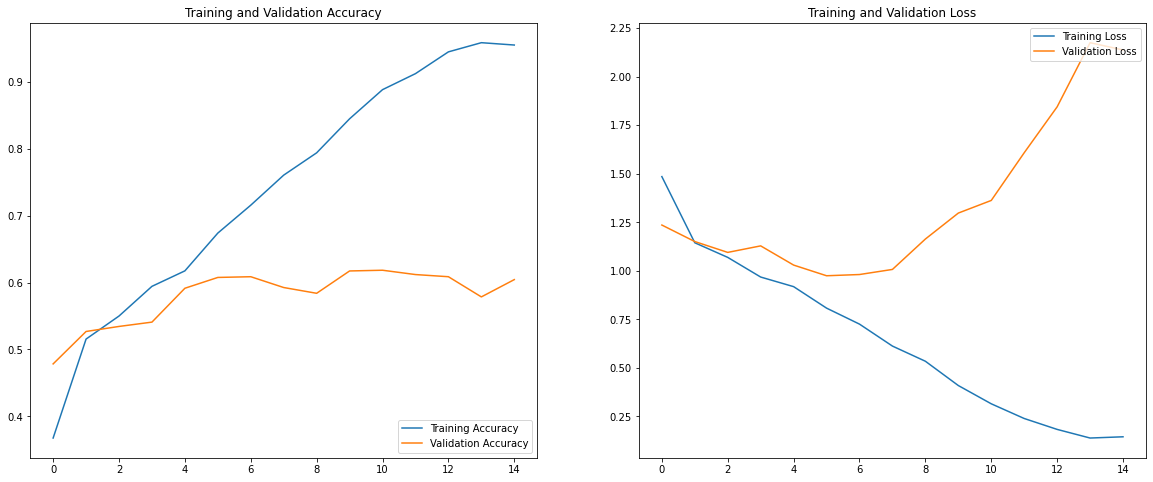

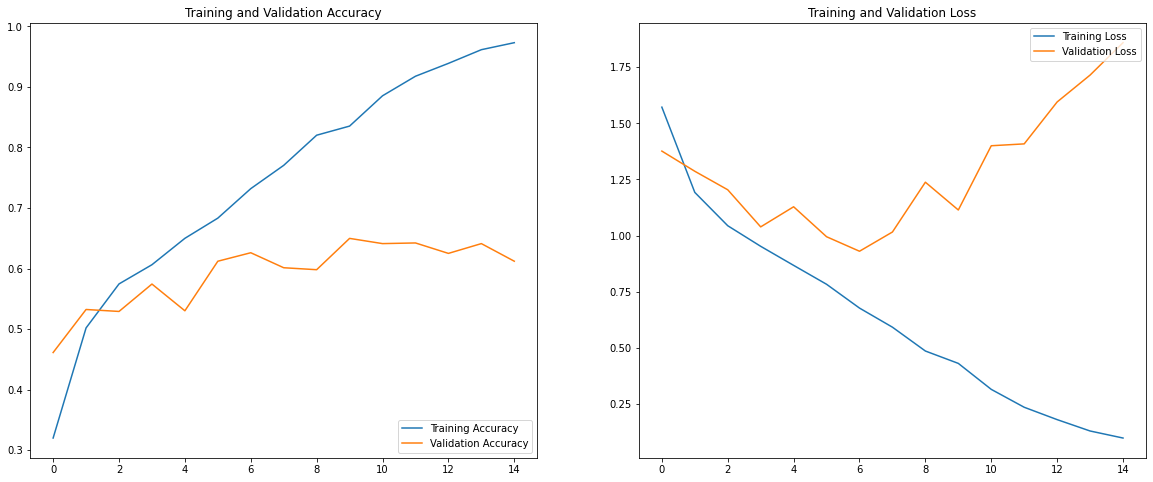

In [ ]:
for history in histories:
  plot_test_val(history,15)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


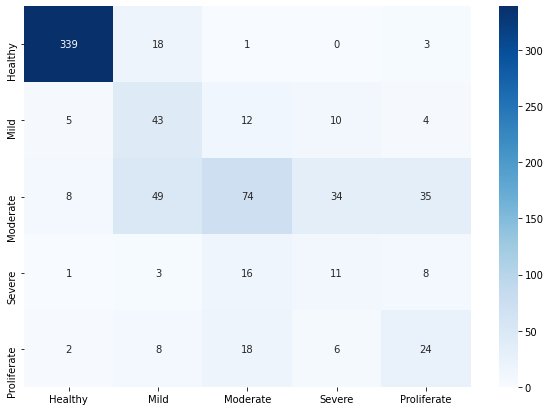

In [ ]:
plot_confusion_matrix(model,test_ds,bin=False)

## Modelo 2

In [ ]:
# Modelo Categorico 2

num_classes = 5

model_2 = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.2),

  layers.Dense(num_classes)
])

In [ ]:
histories = run_model(model_2, name = 'Categorical_sigmax', binary = False, epochs = 50, run_times = 5)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling_9 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 64, 64, 64)      

## Activation Maps

This image most likely belongs to 0 with a 98.04 percent confidence.


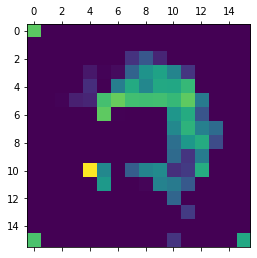

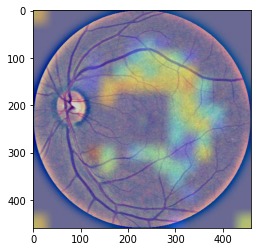

In [ ]:
folder = '/content/drive/MyDrive/datasets/sigmax/sigmax_dataset_categorical/0'
img_code = '0a74c92e287c'
layer = 'conv2d_52'
class_names = train_ds.class_names
heatmap = get_heatmap(model_2, img_code, folder, layer, class_names)
img_path = os.path.join(folder, img_code + '.png')

save_and_display_gradcam(img_path, heatmap, cam_path="cam_2.jpg", alpha=0.4)

pil_im = Image.open('cam_2.jpg', 'r')
imshow(np.asarray(pil_im))

This image most likely belongs to 1 with a 97.22 percent confidence.


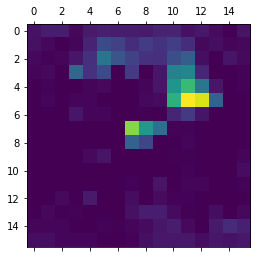

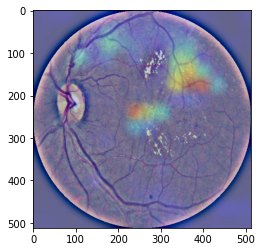

In [ ]:
folder = '/content/drive/MyDrive/datasets/sigmax/sigmax_dataset_categorical/1'
img_code = '1bb0ddfe753a'
layer = 'conv2d_52'
class_names = train_ds.class_names
heatmap = get_heatmap(model_2, img_code, folder, layer, class_names)
img_path = os.path.join(folder, img_code + '.png')

save_and_display_gradcam(img_path, heatmap, cam_path="cam_2.jpg", alpha=0.4)

pil_im = Image.open('cam_2.jpg', 'r')
imshow(np.asarray(pil_im))

This image most likely belongs to 2 with a 97.56 percent confidence.


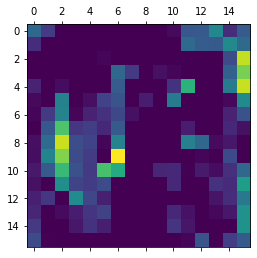

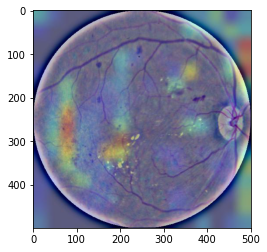

In [ ]:
folder = '/content/drive/MyDrive/datasets/sigmax/sigmax_dataset_categorical/2'
img_code = '0efc93ec838b'
layer = 'conv2d_52'
class_names = train_ds.class_names
heatmap = get_heatmap(model_2, img_code, folder, layer, class_names)
img_path = os.path.join(folder, img_code + '.png')

save_and_display_gradcam(img_path, heatmap, cam_path="cam_2.jpg", alpha=0.4)

pil_im = Image.open('cam_2.jpg', 'r')
imshow(np.asarray(pil_im))

This image most likely belongs to 2 with a 92.59 percent confidence.


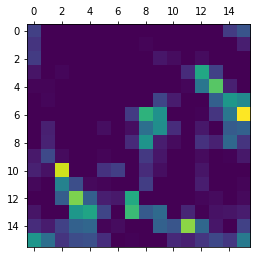

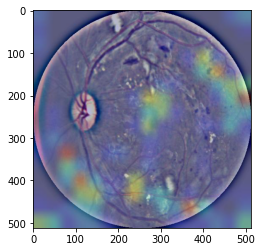

In [ ]:
folder = '/content/drive/MyDrive/datasets/sigmax/sigmax_dataset_categorical/3'
img_code = '2f42e20db938'
layer = 'conv2d_52'
class_names = train_ds.class_names
heatmap = get_heatmap(model_2, img_code, folder, layer, class_names)
img_path = os.path.join(folder, img_code + '.png')

save_and_display_gradcam(img_path, heatmap, cam_path="cam_2.jpg", alpha=0.4)

pil_im = Image.open('cam_2.jpg', 'r')
imshow(np.asarray(pil_im))

This image most likely belongs to 0 with a 98.99 percent confidence.


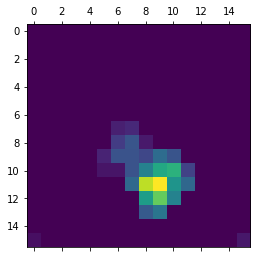

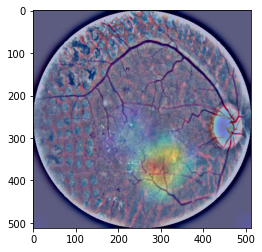

In [ ]:
folder = '/content/drive/MyDrive/datasets/sigmax/sigmax_dataset_categorical/4'
img_code = '3b232b394e4f'
layer = 'conv2d_52'
class_names = train_ds.class_names
heatmap = get_heatmap(model_2, img_code, folder, layer, class_names)
img_path = os.path.join(folder, img_code + '.png')

save_and_display_gradcam(img_path, heatmap, cam_path="cam_2.jpg", alpha=0.4)

pil_im = Image.open('cam_2.jpg', 'r')
imshow(np.asarray(pil_im))

# Save Model

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

# Predict Individual Photos

In [ ]:
img_code = '650104ede84c'
path = os.path.join('/content/drive/MyDrive/datasets/raw_dataset/resized_dataset_512',img_code + '.png')
print('Ground Truth: ',df.loc[df['id_code'] == img_code]['diagnosis'].values[0])

img = keras.preprocessing.image.load_img(path, target_size=(img_height, img_width))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))

Ground Truth:  0
This image most likely belongs to 0 with a 95.82 percent confidence.
